In [30]:
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
shp = "data/ca-places-boundaries/CA_Places_TIGER2016.shp"
gdf = geopandas.read_file(shp)
gdf["area"] = gdf.area
gdf['boundary'] = gdf.boundary
gdf['centroid'] = gdf.centroid
# gdf.explore("area", legend=False)

In [32]:
geojson_file_loc = "data/mapping-la-data-main/geojson/la-county-neighborhoods-v6.geojson"
geo_la_neighborhood = geopandas.read_file(geojson_file_loc)
pop_la_neighborhood = pd.read_csv('data/la-neighborhood-population.csv')

In [33]:
df = geo_la_neighborhood.merge(pop_la_neighborhood, left_on='name', right_on='Neighborhood', how='inner')

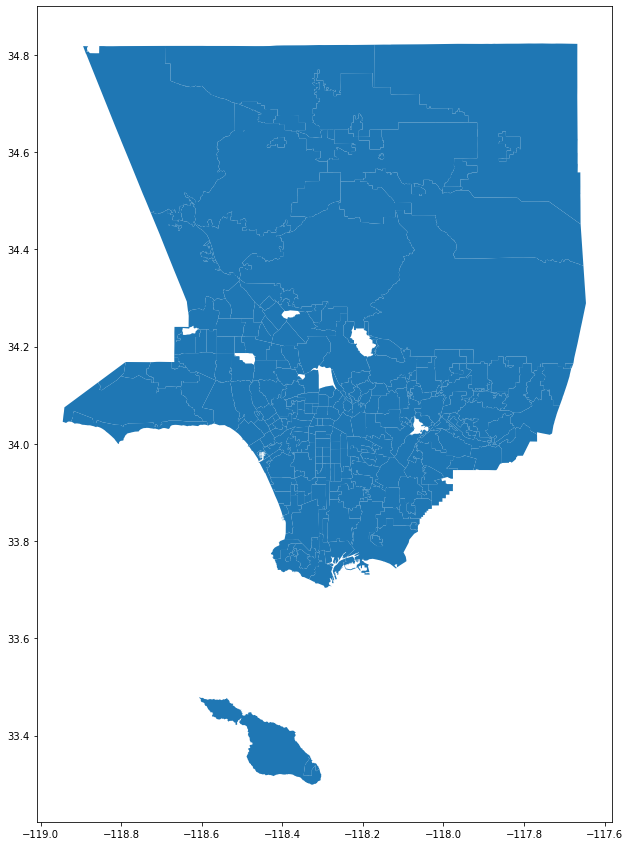

In [34]:
df.plot(figsize=(15,15))
plt.show()